In [1]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
import os
import time
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import lightgbm as lgb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


import phik
from phik.report import plot_correlation_matrix
from phik import report
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm.notebook import tqdm

from src.PM_eq import penman_monteith
from src.process_fluxes import create_rolling_windows

# Data Preprocessing

In [4]:
df = pd.read_csv('../data_v02/validation/validation_dataset.csv')
#df.IGBP = df.IGBP.astype('category')
df

,TIMESTAMP,ETos_daily_in,ETrs_daily_in,site,lat,lon
0,2019-01-01,0.007,0.009,Becker,"0 45.34399\nName: Latitude, dtype: float64","0 -93.85014\nName: Longitude, dtype: float64"
1,2019-01-02,0.013,0.019,Becker,"0 45.34399\nName: Latitude, dtype: float64","0 -93.85014\nName: Longitude, dtype: float64"
2,2019-01-03,0.023,0.033,Becker,"0 45.34399\nName: Latitude, dtype: float64","0 -93.85014\nName: Longitude, dtype: float64"
3,2019-01-04,0.024,0.031,Becker,"0 45.34399\nName: Latitude, dtype: float64","0 -93.85014\nName: Longitude, dtype: float64"
4,2019-01-05,0.025,0.036,Becker,"0 45.34399\nName: Latitude, dtype: float64","0 -93.85014\nName: Longitude, dtype: float64"
...,...,...,...,...,...,...
18278,2022-12-27,0.013,0.018,Westport,"12 45.71509\nName: Latitude, dtype: float64","12 -95.17179\nName: Longitude, dtype: float64"
18279,2022-12-28,0.009,0.01,Westport,"12 45.71509\nName: Latitude, dtype: float64","12 -95.17179\nName: Longitude, dtype: float64"
18280,2022-12-29,0.004,0.004,Westport,"12 45.71509\nName: Latitude, dtype: float64","12 -95.17179\nName: Longitude, dtype: float64"
18281,2022-12-30,0.011,0.013,Westport,"12 45.71509\nName: Latitude, dtype: float64","12 -95.17179\nName: Longitude, dtype: float64"


In [4]:
class Dataset():
    def __init__(self, X, Y, x_scaler=None, y_scaler=None, fit_scaler=False):
        if fit_scaler:
            self.x_scaler = MinMaxScaler()  
            self.y_scaler = MinMaxScaler()  
            X = self.x_scaler.fit_transform(X) 
            Y = self.y_scaler.fit_transform(Y.reshape(-1, 1)) 
        elif x_scaler is not None:
            X = x_scaler.transform(X)  
            Y = y_scaler.transform(Y.reshape(-1, 1)) 
            
        self.x = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32).to(device)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['LE'], axis=1), df['LE'], stratify=df['IGBP'],
                                                    test_size=0.3, shuffle=True, random_state=31)

In [6]:
BATCH_SIZE = 512
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
one_hot = pd.get_dummies(X_train.IGBP)
X_train = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
one_hot = pd.get_dummies(X_test.IGBP)
X_test = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)

In [11]:
train_dataset = Dataset(X_train, y_train.values, fit_scaler=True)
x_scaler = train_dataset.x_scaler 
y_scaler = train_dataset.y_scaler 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=False)
test_loader = DataLoader(Dataset(X_test.values, y_test.values,
                                 x_scaler=x_scaler, y_scaler=y_scaler), batch_size=BATCH_SIZE, drop_last=False)

# ANN

In [12]:
class ANN(nn.Module):
    def __init__(self, INPUT_SIZE, n1, n2, dropout=0.3):
        super().__init__()
	
        self.net = nn.Sequential()
        self.net.add_module('Linear_1', nn.Linear(INPUT_SIZE, n1))
        self.net.add_module('ReLU_1', nn.Tanh()) #Sigmoid
        self.net.add_module('Drop_1', nn.Dropout(dropout))
        
        self.net.add_module('Linear_2', torch.nn.Linear(n1, n2))
        self.net.add_module('Norm', nn.BatchNorm1d(n2))
        self.net.add_module('ReLU_2', nn.Tanh())
        self.net.add_module('Drop_2', nn.Dropout(dropout))
        self.net.add_module('Linear_3',torch.nn.Linear(n2, 1))

    def forward(self, y):
        return self.net(y)

In [13]:
num_epoch = 200
feature_num = X_test.values.shape[1]
n1 = 400
n2 = 100
dropout=0.3

In [14]:
model = ANN(feature_num, n1,n2, dropout).to(device).to(torch.float32)

In [15]:
model.load_state_dict(torch.load('../models/ANN.pth'))

<All keys matched successfully>

In [17]:
criteria = nn.MSELoss()

In [18]:
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(torch.float32), y.to(torch.float32)
        preds = model(x)
        preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
        y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
        test_preds.append(torch.tensor(preds))
        test_true.append(torch.tensor(y_scaled))

test_preds = torch.cat(test_preds).squeeze()
test_true = torch.cat(test_true).squeeze()

test_loss = criteria(test_preds, test_true).item()
r2 = r2_score(test_true.numpy(), test_preds.numpy())
mae = mean_absolute_error(test_true.numpy(), test_preds.numpy())
print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t Test MAE: {mae:0.4f}')

ann_preds = pd.DataFrame({"LE":test_preds.numpy()})
Y_test = pd.DataFrame({"LE":np.array(y_test)})
resid = pd.DataFrame({"LE":ann_preds.LE - Y_test.LE})

Test RMSE: 11.236		Test R2: 0.9225		 Test MAE: 7.4273


# LightGBM

In [24]:
lgbm = lgb.Booster(model_file='../models/lightgbm_model.txt') #R2: 0.882	RMSE: 0.821

In [25]:
y_pred_lgb = lgbm.predict(X_test)

# XGBoost

In [32]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.load_model("../models/xgboost_model.json")

In [33]:
y_pred_xgb = model.predict(X_test)

# CatBoost

In [118]:
from catboost import CatBoostRegressor
model = CatBoostRegressor()
model.load_model("../models/catboost_model.cbm")

In [119]:
y_pred_cb = model.predict(X_test)

# RF

In [113]:
import pickle
with open("../models/rf_model.pkl", "rb") as f:
    model = pickle.load(f)

In [39]:
y_pred_rf = model.predict(X_test)

# Visuals

In [120]:
df = pd.DataFrame({
    'true': y_test,
    'XGBoost': y_pred_xgb,
    'Light GBM': y_pred_lgb,
    'Random Forest': y_pred_rf,
    'CatBoost': y_pred_cb,
    'Artificial Neural Network': ann_preds.values[:,0],
})

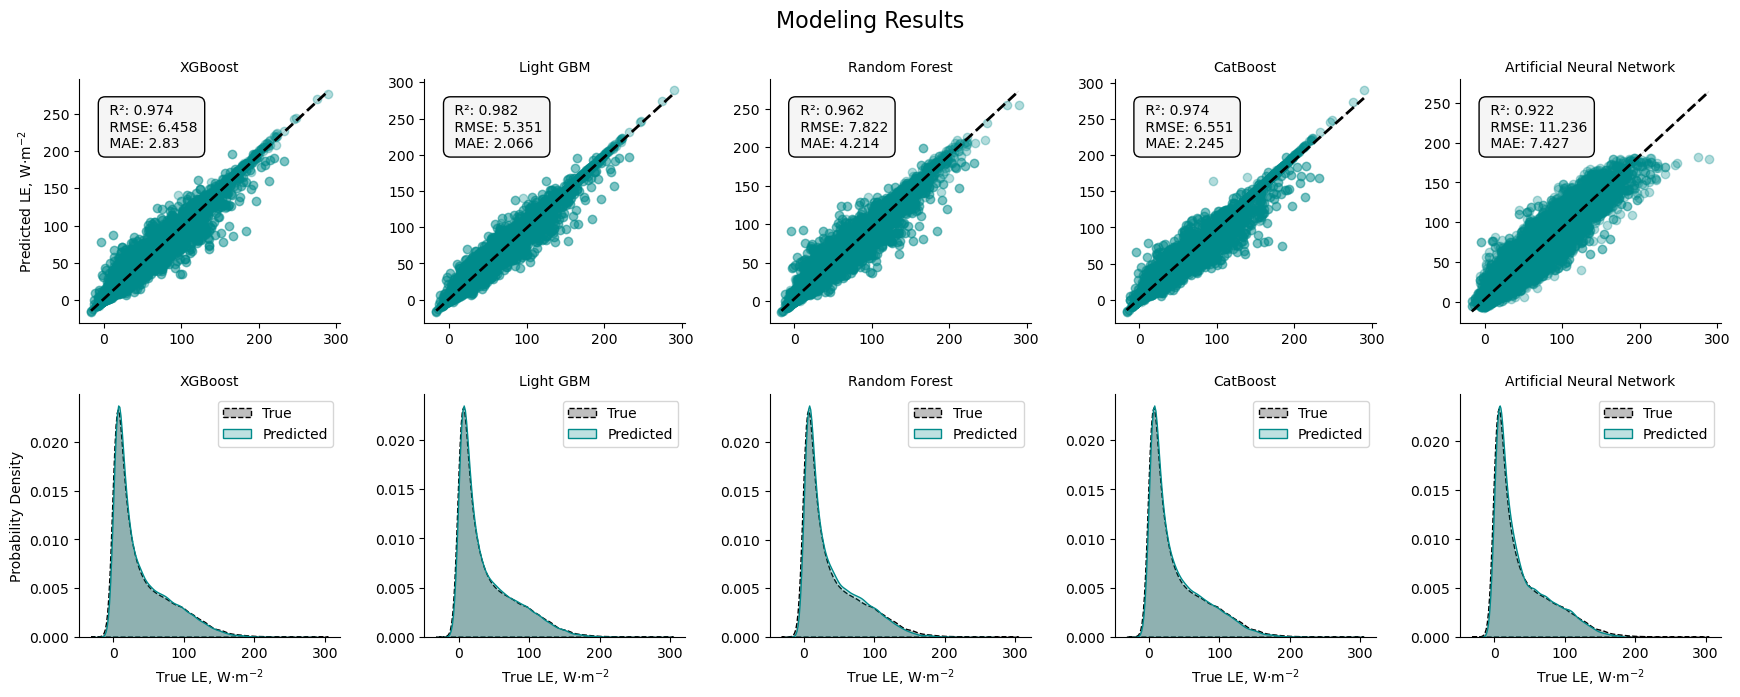

In [121]:
df_long = df.melt(id_vars='true', var_name='Model', value_name='Prediction')
df_long['Plot_Type'] = 'KDE'
df_scatter = df_long.copy()
df_scatter['Plot_Type'] = 'Scatter'
df_both = pd.concat([df_scatter, df_long], ignore_index=True)

g = sns.FacetGrid(df_both, col="Model", row="Plot_Type", height=3.5,
                  sharex=False, sharey=False)

def custom_plot(data, color, **kwargs):
    if data['Plot_Type'].iloc[0] == 'KDE':
        sns.kdeplot(data['true'], label="True", color="black", linestyle="--", fill=True)
        sns.kdeplot(data['Prediction'], label="Predicted", color='darkcyan', fill=True)
    else:
        sns.regplot(x='true', y='Prediction', data=data, scatter_kws={'alpha':0.3, 'color':'darkcyan'}, line_kws={'color':'black', 'ls': '--', 'lw':2},)

g.map_dataframe(custom_plot)

g.set_titles(template="{col_name}")
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle("Modeling Results", fontsize=16)

for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == 'KDE':
        ax.legend()
    elif row_val == 'Scatter' and ax.legend_:
        ax.legend_.remove()
        


for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == 'Scatter':
        r2 = round(r2_score(df.true, df[col_val]),3)
        rmse = round(mean_squared_error(df.true, df[col_val])**0.5,3)
        mae = round(mean_absolute_error(df.true, df[col_val]),3)
        info_text = f" R\u00b2: {r2} \n RMSE: {rmse}\n MAE: {mae}"
        ax.text(0.1, 0.9, info_text, transform=ax.transAxes,
                ha='left', va='top', fontsize=10,
               bbox=dict(facecolor='whitesmoke', edgecolor='black',boxstyle='round,pad=0.5'))
    
    if col_val != 'XGBoost':
        ax.set_ylabel('')
    elif col_val == 'XGBoost' and row_val == 'KDE':
        ax.set_ylabel('Probability Density')
    else:
        ax.set_ylabel('Predicted LE, W\u22C5m$^{-2}$')

    if row_val != 'KDE':
        ax.set_xlabel('')
    else:
        ax.set_xlabel('True LE, W\u22C5m$^{-2}$')
        
plt.savefig('../fig/model_comparison.png')
plt.show()